In [5]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

In [6]:
import phate

In [7]:
os.chdir('..')
import manifold_methods
import plotting
import mappings
import data_loader

In [8]:
exp_path = '/lustre06/project/6065672/shared/1000G_HGDP_merged_dataset/PASSfiltered'
fname = 'gnomad.genomes.v3.1.2.hgdp_tgp.PASSfiltered.newIDs.onlySNPs.noDuplicatePos.noMiss5perc.maf0.01.LDpruned100_50_0.05.noHLA.woLowComplexity.recoded.hdf5'

In [10]:
with h5py.File(os.path.join(exp_path,fname), 'r') as hf:
    inputs = hf['inputs'][:] 

In [ ]:
inputs, class_labels, samples, snp_names, class_label_names = data_loader.load_data_1000G(os.path.join(exp_path, fname))
label_with_names, label_with_superpop_names = data_loader.preprocess_labels_1000G(class_labels, class_label_names)

In [12]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs)

In [13]:
# initial 2D phate embedding
phate_operator42_2d = phate.PHATE(random_state=42, 
                                  n_components=2, 
                                  knn=5, 
                                  n_pca=None,
                                  decay=60,
                                  t=5)
phate_operator42_2d.fit(pca_input)
phate_emb42_2d = phate_operator42_2d.transform()

Running PHATE on 4151 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 1.07 seconds.
  Calculating affinities...
  Calculated affinities in 0.26 seconds.
Calculated graph and diffusion operator in 1.36 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.23 seconds.
  Calculating KMeans...
  Calculated KMeans in 3.29 seconds.
Calculated landmark operator in 4.15 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.96 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.15 seconds.


<Axes: >

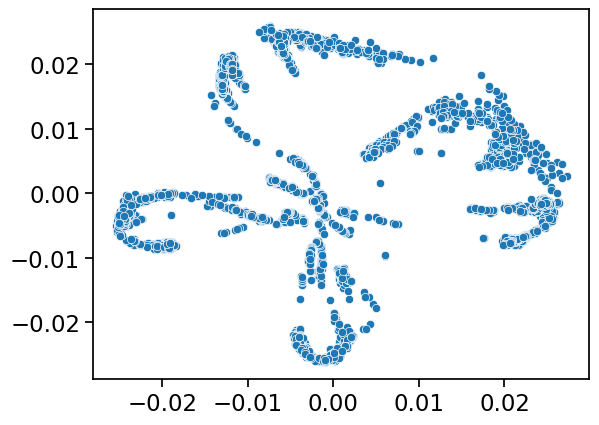

In [14]:
sns.scatterplot(x=phate_emb42_2d[:,0], y=phate_emb42_2d[:,1])

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

# initial 2D phate embedding
plotting.plot_embeddings(phate_emb42_2d, 
                         label_with_superpop_names, 
                         None,
                         mappings.pop_pallette_1000G_coarse,
                         mappings.label_order_1000G_coarse,
                         True,
                         ax[0])
plotting.plot_embeddings(phate_emb42_2d, 
                         label_with_names,
                         None,
                         mappings.pop_pallette_1000G_fine,
                         mappings.label_order_1000G_fine,
                         True,
                         ax[1])
plt.tight_layout()

In [ ]:
def load_admix_ratio(sample_ids_path, admix_ratios_path, samples, labels):
    admix_labels = np.zeros([len(samples), 3])

    sample_ids = pd.read_csv(sample_ids_path, sep=' ', header=None)
    admix_ratios = pd.read_csv(admix_ratios_path, sep=' ', header=None)

    admix_df = pd.concat([admix_ratios, sample_ids], axis=1)
    admix_df.columns = ['admix 1', 'admix 2', 'admix 3' , 'sample id']

    matching_indices = np.array([np.where(admix_df['sample id'][j] == samples)[0][0] if len(np.where(admix_df['sample id'][j] == samples)[0]) > 0 else -1 for j in range(len(admix_df))])
    for i, idx in enumerate(matching_indices):
        if idx != -1:
            admix_labels[idx] = admix_df.iloc[i].values[:3]

    # color in all EUR or AFR individuals as 1
    admix_labels_inc_EURAFR = admix_labels
    admix_labels_inc_EURAFR[labels == 'EUR', 2] = 1
    admix_labels_inc_EURAFR[labels == 'AFR', 0] = 1

    return admix_labels, admix_labels_inc_EURAFR

In [ ]:
data_path = '/lustre07/scratch/sciclun4/data/1000G/phate_genetics/MyAdmix'
sample_ids_path = os.path.join(data_path, 'output_ids.txt')
admix_ratios_path = os.path.join(data_path, 'AMR_ACB_ASW.3.Q')

admix_labels, admix_labels_inc_EURAFR = load_admix_ratio(sample_ids_path, 
                                                         admix_ratios_path,
                                                         samples,
                                                         class_labels)

## 2D Embedding With Admixture

In [ ]:
# initial 2D phate embedding
fig, ax = plt.subplots(ncols=3, figsize=(30,10))
    
plotting.plot_embeddings(phate_emb42_2d, 
                         admix_labels_inc_EURAFR[:,1],
                         None,
                         None,
                         None,
                         True,
                         ax[0])
ax[0].set_title("Amerindigenous ancestry (%)", fontsize=12)
plotting.plot_embeddings(phate_emb42_2d, 
                         admix_labels_inc_EURAFR[:,0],
                         None,
                         None,
                         None,
                         True,
                         ax[1])
ax[1].set_title("African ancestry (%)", fontsize=12)
plotting.plot_embeddings(phate_emb42_2d, 
                         admix_labels_inc_EURAFR[:,2],
                         None,
                         None,
                         None,
                         True,
                         ax[2])
ax[2].set_title("European ancestry (%)", fontsize=12)
plt.tight_layout()

## PHATE Defaults

In [ ]:
# initial phate embedding
phate_operator_3d = phate.PHATE(random_state=42, 
                                n_components=3, 
                                knn=5, 
                                decay=60,
                                n_pca=None)
phate_operator_3d.fit(pca_input)
phate_emb_3d = phate_operator_3d.transform()

In [ ]:
import scprep
scprep.plot.scatter3d(phate_emb_3d, 
                      c=label_with_superpop_names, 
                      figsize=(8,6),
                      cmap=mappings.pop_pallette_1000G_coarse,
                      ticks=False, label_prefix="PHATE")

In [ ]:
scprep.plot.rotate_scatter3d(phate_emb_3d, 
                             c=label_with_superpop_names, 
                             figsize=(8,6),
                             cmap=mappings.pop_pallette_1000G_coarse,
                             ticks=False, 
                             label_prefix="PHATE")

In [ ]:
scprep.plot.scatter3d(phate_emb_3d, 
                      c=label_with_names, 
                      figsize=(8,6),
                      cmap=mappings.pop_pallette_1000G_fine,
                      ticks=False, 
                      label_prefix="PHATE")

In [ ]:
scprep.plot.rotate_scatter3d(phate_emb_3d, 
                             c=label_with_names, 
                             figsize=(8,6),
                             cmap=mappings.pop_pallette_1000G_fine,
                             ticks=False, 
                             label_prefix="PHATE")

## Admix Ratios

In [ ]:
#"African ancestry (%)"
scprep.plot.rotate_scatter3d(phate_emb_3d, 
                              c=admix_labels_inc_EURAFR[:,0], 
                              figsize=(8,6),
                              cmap='Reds',
                              ticks=False, label_prefix="PHATE")

In [ ]:
#"Amerindigenous ancestry (%)"
scprep.plot.rotate_scatter3d(phate_emb_3d, 
                             c=admix_labels_inc_EURAFR[:,1], 
                             figsize=(8,6),
                             cmap='Reds',
                             ticks=False, label_prefix="PHATE")

In [ ]:
#"European ancestry (%)"
scprep.plot.rotate_scatter3d(phate_emb_3d, 
                             c=admix_labels_inc_EURAFR[:,2], 
                             figsize=(8,6),
                             cmap='Reds',
                             ticks=False, label_prefix="PHATE")